In [3]:
import pandas as pd
import glob
import os
import numpy as np
import sys
! pip install pmcx
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
from pathlib import Path
import os, re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 1.2 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)
from FD_msNIRS_2layers import extract_freq as ef

Mounted at /content/drive


### Single SD

In [ ]:
import os, re
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def compute_fd_td_metrics(folder_path):
    # mapping from file‐index (1…8) → actual S‑D distance (mm)
    sd_map = {i+1: dist for i, dist in enumerate([10, 15, 20, 25, 30, 35, 40, 45])}

    # metrics[domain]['HHB2'|'HBO2'][distance_mm] = {'MARE(%)': ..., 'RMSE': ...}
    metrics = {
        'FD': {'HHB2': {}, 'HBO2': {}},
        'TD': {'HHB2': {}, 'HBO2': {}},
    }

    # distance_1_hhb2_TD.csv  /  distance_3_hbo2_fd.csv  (case‑insensitive)
    pattern = re.compile(r'distance_(\d+)_(hhb2|hbo2)_(TD|FD)\.csv', re.IGNORECASE)

    for fname in os.listdir(folder_path):
        m = pattern.match(fname)
        if not m:
            continue

        idx     = int(m.group(1))           # 1…8
        chrom   = m.group(2).upper()        # HHB2 or HBO2
        domain  = m.group(3).upper()        # TD or FD
        dist    = sd_map[idx]
        path    = os.path.join(folder_path, fname)

        df      = pd.read_csv(path)
        y_pred  = df['y_pred'].to_numpy()
        y_true  = df['y_test'].to_numpy()

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        # small epsilon to avoid div-by-zero explosions
        mare = np.mean(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-12)) * 100

        metrics[domain][chrom][dist] = {'MARE(%)': mare, 'RMSE': rmse}

    # sort inner dicts by distance
    for domain in metrics:
        for chrom in metrics[domain]:
            metrics[domain][chrom] = dict(sorted(metrics[domain][chrom].items()))

    return metrics

def print_metrics(metrics):
    for domain in ['FD', 'TD']:
        print(f"{'Frequency' if domain=='FD' else 'Time'}‑Domain Metrics:")
        for chrom in ['HHB2', 'HBO2']:
            if not metrics[domain][chrom]:
                continue
            print(f"  {chrom}:")
            for dist, mets in metrics[domain][chrom].items():
                print(f"    {dist} mm → MARE={mets['MARE(%)']:.4f}%, RMSE={mets['RMSE']:.4f}")
        print()

# usage
folder = '/content/drive/MyDrive/MCX_data/distance_1/'
metrics = compute_fd_td_metrics(folder)
print_metrics(metrics)

Frequency‑Domain Metrics:
  HHB2:
    10 mm → MARE=18.2786%, RMSE=5.0476
    15 mm → MARE=16.6249%, RMSE=4.7767
    20 mm → MARE=16.4030%, RMSE=4.5615
    25 mm → MARE=16.6459%, RMSE=4.5980
    30 mm → MARE=15.7848%, RMSE=4.5435
    35 mm → MARE=15.7421%, RMSE=4.4597
    40 mm → MARE=16.1386%, RMSE=4.5877
    45 mm → MARE=16.2113%, RMSE=4.6827
  HBO2:
    10 mm → MARE=17.2039%, RMSE=7.6523
    15 mm → MARE=16.6402%, RMSE=7.4466
    20 mm → MARE=13.5504%, RMSE=6.3919
    25 mm → MARE=13.0827%, RMSE=5.9573
    30 mm → MARE=12.6473%, RMSE=5.7778
    35 mm → MARE=11.8098%, RMSE=5.7216
    40 mm → MARE=13.2173%, RMSE=6.3276
    45 mm → MARE=14.2596%, RMSE=6.6185

Time‑Domain Metrics:
  HHB2:
    10 mm → MARE=5.0252%, RMSE=1.7374
    15 mm → MARE=5.4877%, RMSE=1.8644
    20 mm → MARE=5.1223%, RMSE=1.6983
    25 mm → MARE=5.4350%, RMSE=1.7780
    30 mm → MARE=5.2375%, RMSE=1.7045
    35 mm → MARE=5.9674%, RMSE=1.9659
    40 mm → MARE=5.7404%, RMSE=1.9246
    45 mm → MARE=6.8539%, RMSE=2.1569


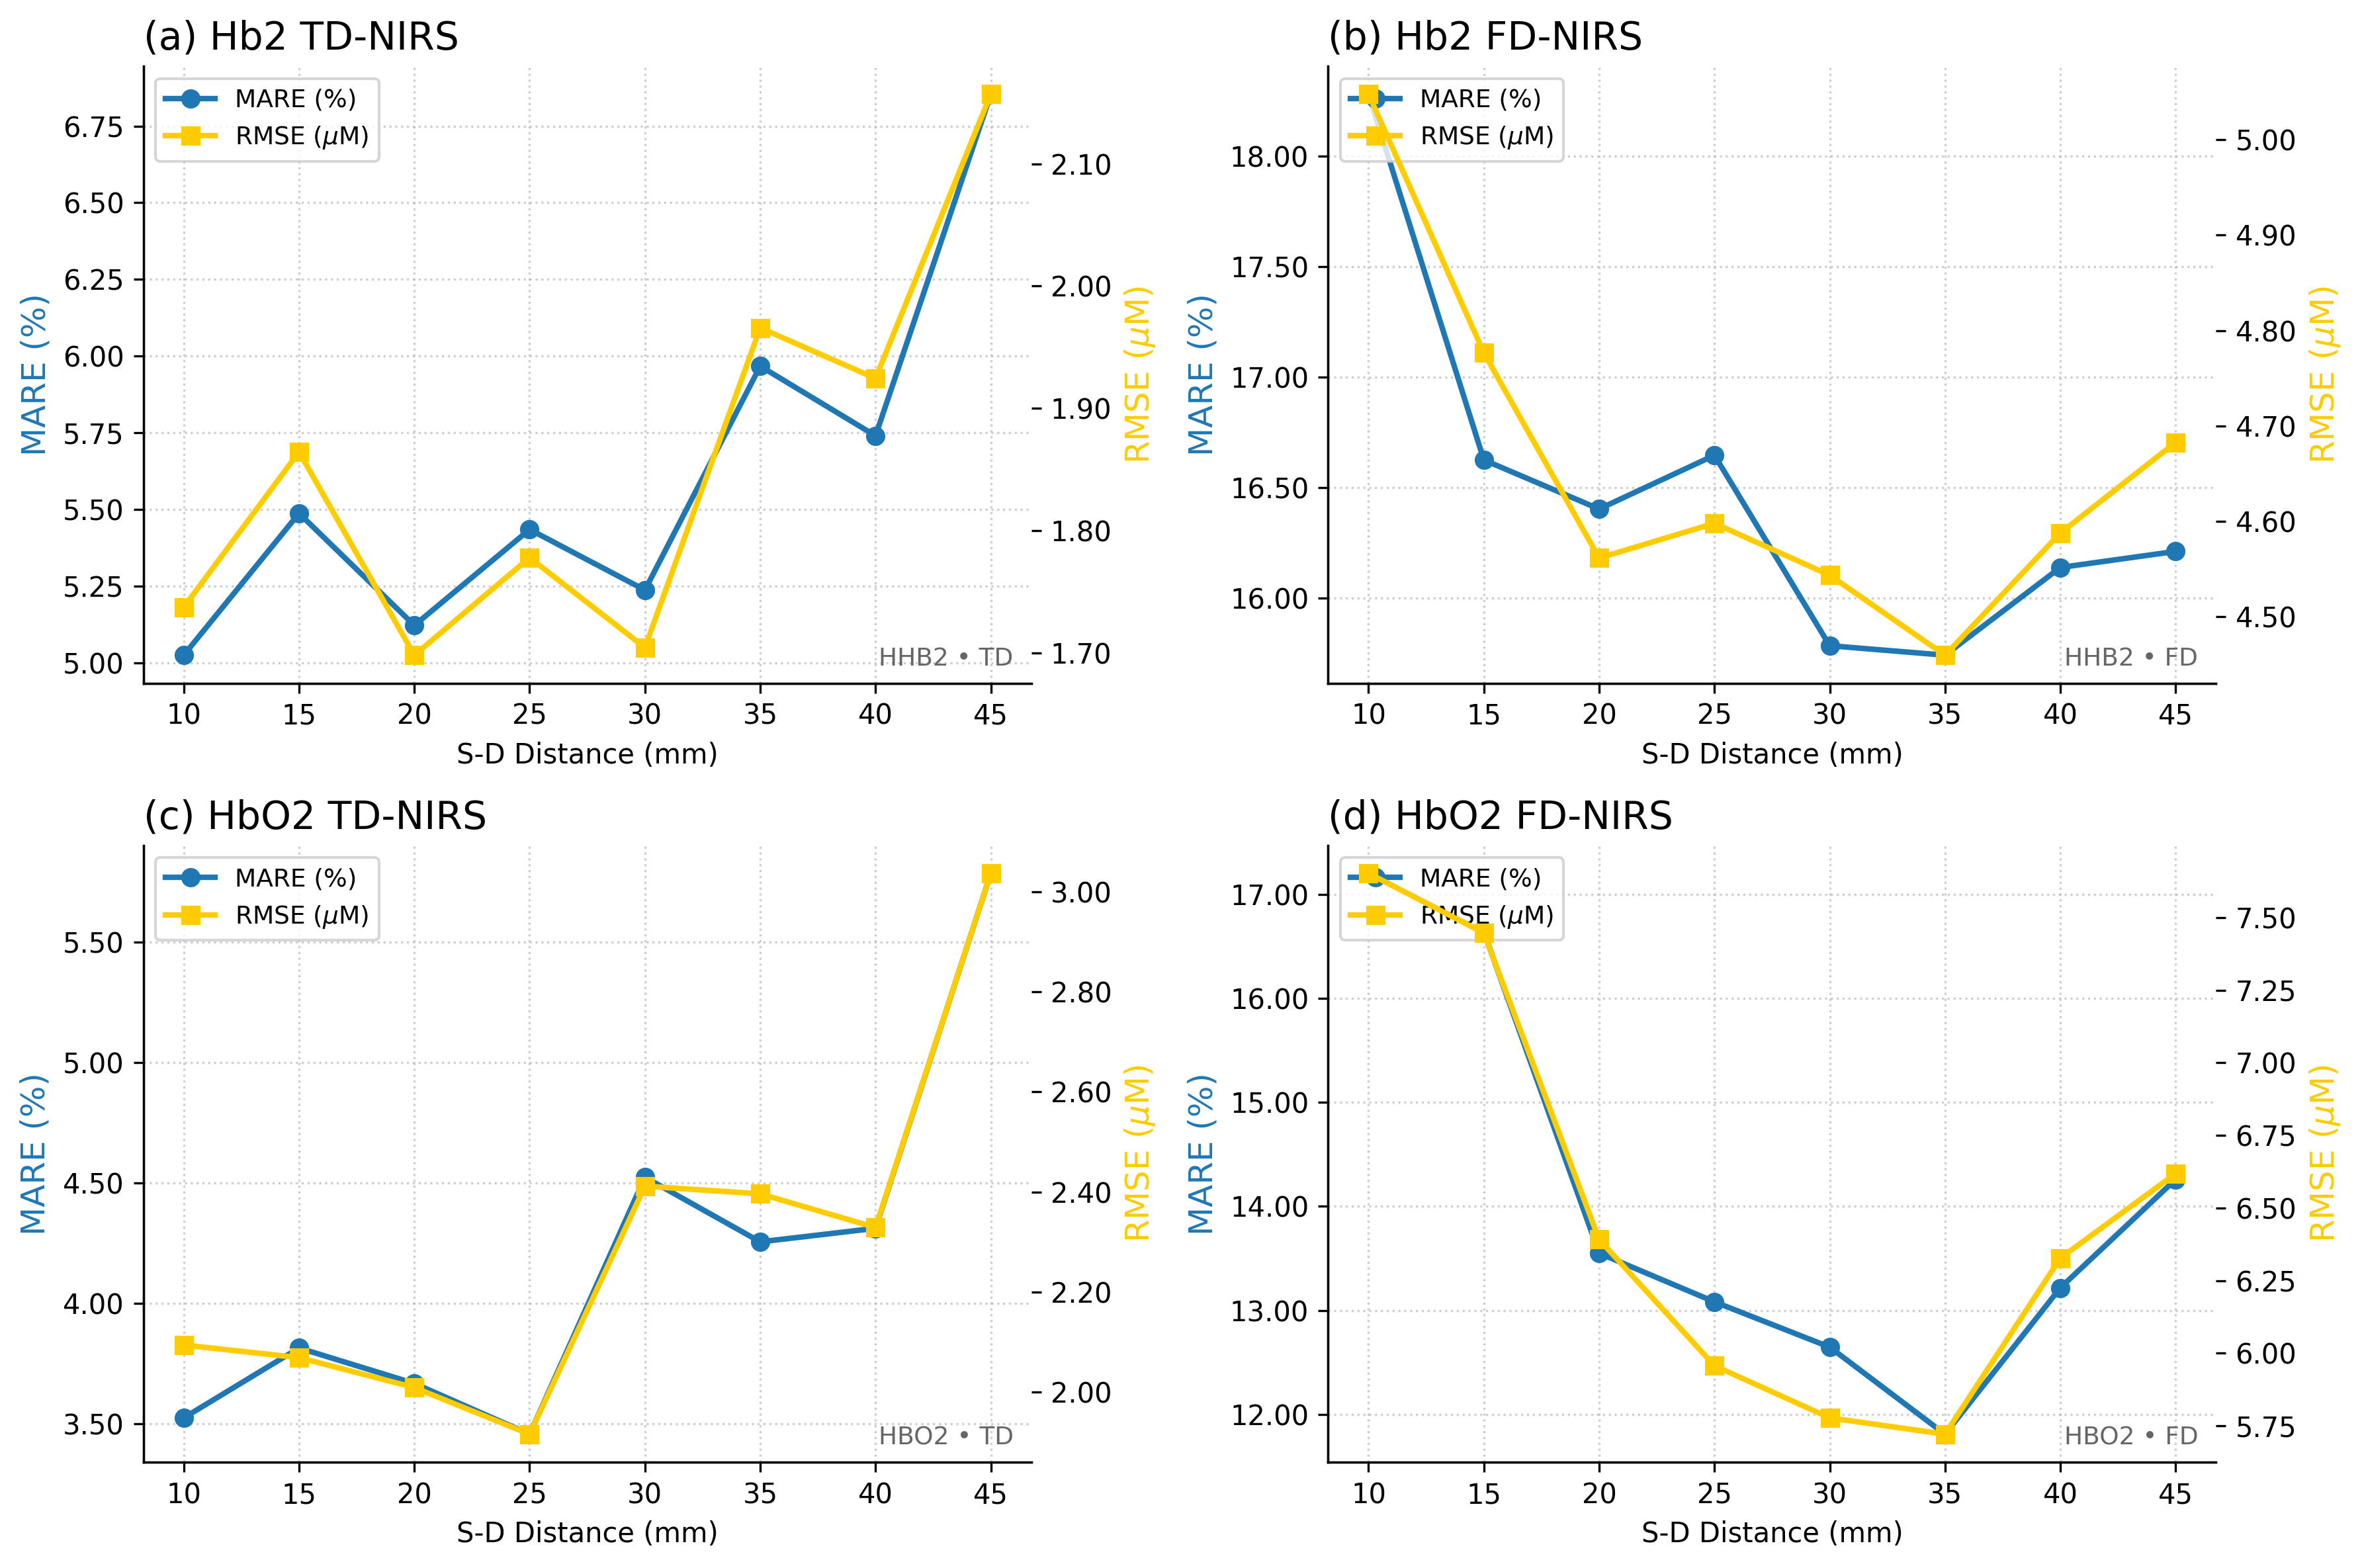

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

BLUE   = "#1f77b4"
YELLOW = "#ffcc00"

def plot_fd_td_metrics_2x2(metrics):
    """
    metrics[domain]['HHB2'|'HBO2'][distance_mm] = {'MARE(%)': ..., 'RMSE': ...}
    domain ∈ {'TD','FD'}
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300)

    panels = [
        ('HHB2', 'TD', (0, 0), '(a) Hb2 TD‑NIRS'),
        ('HHB2', 'FD', (0, 1), '(b) Hb2 FD‑NIRS'),
        ('HBO2', 'TD', (1, 0), '(c) HbO2 TD‑NIRS'),
        ('HBO2', 'FD', (1, 1), '(d) HbO2 FD‑NIRS'),
    ]

    for chrom, domain, (r, c), title in panels:
        ax = axes[r][c]
        data = metrics.get(domain, {}).get(chrom, {})
        if not data:   # nothing to plot
            ax.set_visible(False)
            continue

        dists = sorted(data.keys())
        mare  = [data[d]['MARE(%)'] for d in dists]
        rmse  = [data[d]['RMSE']    for d in dists]

        ax2 = ax.twinx()

        ax.set_title(title, loc='left', fontsize=14)
        l1 = ax.plot(dists, mare, marker='o', lw=2, ms=6, label='MARE (%)', color=BLUE)
        l2 = ax2.plot(dists, rmse, marker='s', lw=2, ms=6, label=r'RMSE ($\mu$M)', color=YELLOW)

        ax.set_xlabel('S‑D Distance (mm)', fontsize=10)
        ax.set_ylabel('MARE (%)', color=BLUE, fontsize=12)
        ax2.set_ylabel(r'RMSE ($\mu$M)', color=YELLOW, fontsize=12)

        # nice decimals (optional; remove if you don't want fixed formatting)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        for a in (ax, ax2):
            a.spines['top'].set_visible(False)
            a.spines['right'].set_visible(False)
            a.tick_params(labelsize=10)

        lines  = l1 + l2
        labels = [ln.get_label() for ln in lines]
        ax.legend(lines, labels, loc='upper left', fontsize=9)

        ax.grid(True, linestyle=':', alpha=0.6)

        ax.text(0.98, 0.02, f'{chrom} • {domain}',
                transform=ax.transAxes, fontsize=9, ha='right', va='bottom',
                color='0.4')

    plt.tight_layout()
    plt.show()

# usage
# metrics = compute_fd_td_metrics(folder)
plot_fd_td_metrics_2x2(metrics)


### Many SD

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from sklearn.metrics import mean_squared_error

def compute_fd_td_metrics_all(folder_path: str) -> Tuple[Dict, Dict]:
    """
    Reads all CSVs named:
        distance_{key}_{hhb2|hbo2}_{FD|TD}.csv
    computes MARE(%) and RMSE, and returns:

      fd_metrics = {
          'HHB2': { key: {'MARE(%)': ..., 'RMSE': ...}, ... },
          'HBO2': { key: {'MARE(%)': ..., 'RMSE': ...}, ... },
      }

      td_metrics = {
          'HHB2': { ... },
          'HBO2': { ... },
      }
    """
    fd_metrics = {'HHB2': {}, 'HBO2': {}}
    td_metrics = {'HHB2': {}, 'HBO2': {}}

    pattern = re.compile(r'distance_(\d+)_(hhb2|hbo2)_(FD|TD)\.csv', re.IGNORECASE)

    for fname in os.listdir(folder_path):
        m = pattern.match(fname)
        if not m:
            continue

        key     = int(m.group(1))          # e.g. 123, 1234, …
        chrom   = m.group(2).upper()       # HHB2 or HBO2
        domain  = m.group(3).upper()       # FD or TD
        path    = os.path.join(folder_path, fname)

        df      = pd.read_csv(path)
        y_pred  = df['y_pred'].to_numpy()
        y_true  = df['y_test'].to_numpy()

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mare = np.mean(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-12)) * 100

        entry = {'MARE(%)': mare, 'RMSE': rmse}
        if domain == 'FD':
            fd_metrics[chrom][key] = entry
        else:
            td_metrics[chrom][key] = entry

    # sort by key inside each chromophore
    for chrom in fd_metrics:
        fd_metrics[chrom] = dict(sorted(fd_metrics[chrom].items()))
    for chrom in td_metrics:
        td_metrics[chrom] = dict(sorted(td_metrics[chrom].items()))

    return fd_metrics, td_metrics

folder = '/content/drive/MyDrive/MCX_data/distance_all/'
fd_metrics, td_metrics = compute_fd_td_metrics_all(folder)

In [ ]:
## hhb2 Update values from previous results
td_metrics['HHB2'][12345678] = {'MARE(%)': np.float64(2.614),
 'RMSE': np.float64(0.957)}
td_metrics['HHB2'][12] = {'MARE(%)': np.float64(3.72),
 'RMSE': np.float64(1.3343)}
##
fd_metrics['HHB2'][12345678] = {'MARE(%)': np.float64(7.262),
 'RMSE': np.float64(2.185)}
fd_metrics['HHB2'][12] = {'MARE(%)': np.float64(13.03),
 'RMSE': np.float64(3.7912)}

## hbo2
td_metrics['HBO2'][12345678] = {'MARE(%)': np.float64(2.218),
 'RMSE': np.float64(1.610)}
td_metrics['HBO2'][12] = {'MARE(%)': np.float64(3.406),
 'RMSE': np.float64(2.0305)}
##
fd_metrics['HBO2'][12345678] = {'MARE(%)': np.float64(5.014),
 'RMSE': np.float64(2.575)}
fd_metrics['HBO2'][12] = {'MARE(%)': np.float64(13.3466),
 'RMSE': np.float64(6.1128)}

def print_all_metrics(fd_metrics, td_metrics):
    for domain, metrics in (('FD', fd_metrics), ('TD', td_metrics)):
        print(f"\n{domain} metrics")
        for chrom in ('HHB2', 'HBO2'):
            data = metrics.get(chrom, {})
            if not data:
                print(f"  {chrom}: (none)")
                continue
            print(f"  {chrom}:")
            for key, vals in data.items():
                print(f"    {key} → MARE={vals['MARE(%)']:.4f}%, RMSE={vals['RMSE']:.6f}")

In [ ]:
print_all_metrics(fd_metrics, td_metrics)


FD metrics
  HHB2:
    123 → MARE=10.7465%, RMSE=3.257386
    1234 → MARE=8.1554%, RMSE=2.660663
    12345 → MARE=8.5006%, RMSE=2.672645
    123456 → MARE=7.7123%, RMSE=2.256110
    1234567 → MARE=6.6986%, RMSE=2.020072
    12345678 → MARE=7.2620%, RMSE=2.185000
    12 → MARE=13.0300%, RMSE=3.791200
  HBO2:
    123 → MARE=10.0983%, RMSE=5.021561
    1234 → MARE=8.7451%, RMSE=4.371790
    12345 → MARE=7.0418%, RMSE=3.419070
    123456 → MARE=5.6489%, RMSE=2.866727
    1234567 → MARE=5.2655%, RMSE=2.573023
    12345678 → MARE=5.0140%, RMSE=2.575000
    12 → MARE=13.3466%, RMSE=6.112800

TD metrics
  HHB2:
    123 → MARE=3.3106%, RMSE=1.279780
    1234 → MARE=3.0528%, RMSE=1.148102
    12345 → MARE=2.7192%, RMSE=1.053779
    123456 → MARE=3.0801%, RMSE=1.057583
    1234567 → MARE=2.8954%, RMSE=1.054313
    12345678 → MARE=2.6140%, RMSE=0.957000
    12 → MARE=3.7200%, RMSE=1.334300
  HBO2:
    123 → MARE=3.1072%, RMSE=1.933164
    1234 → MARE=2.7611%, RMSE=1.691416
    12345 → MARE=2.1898

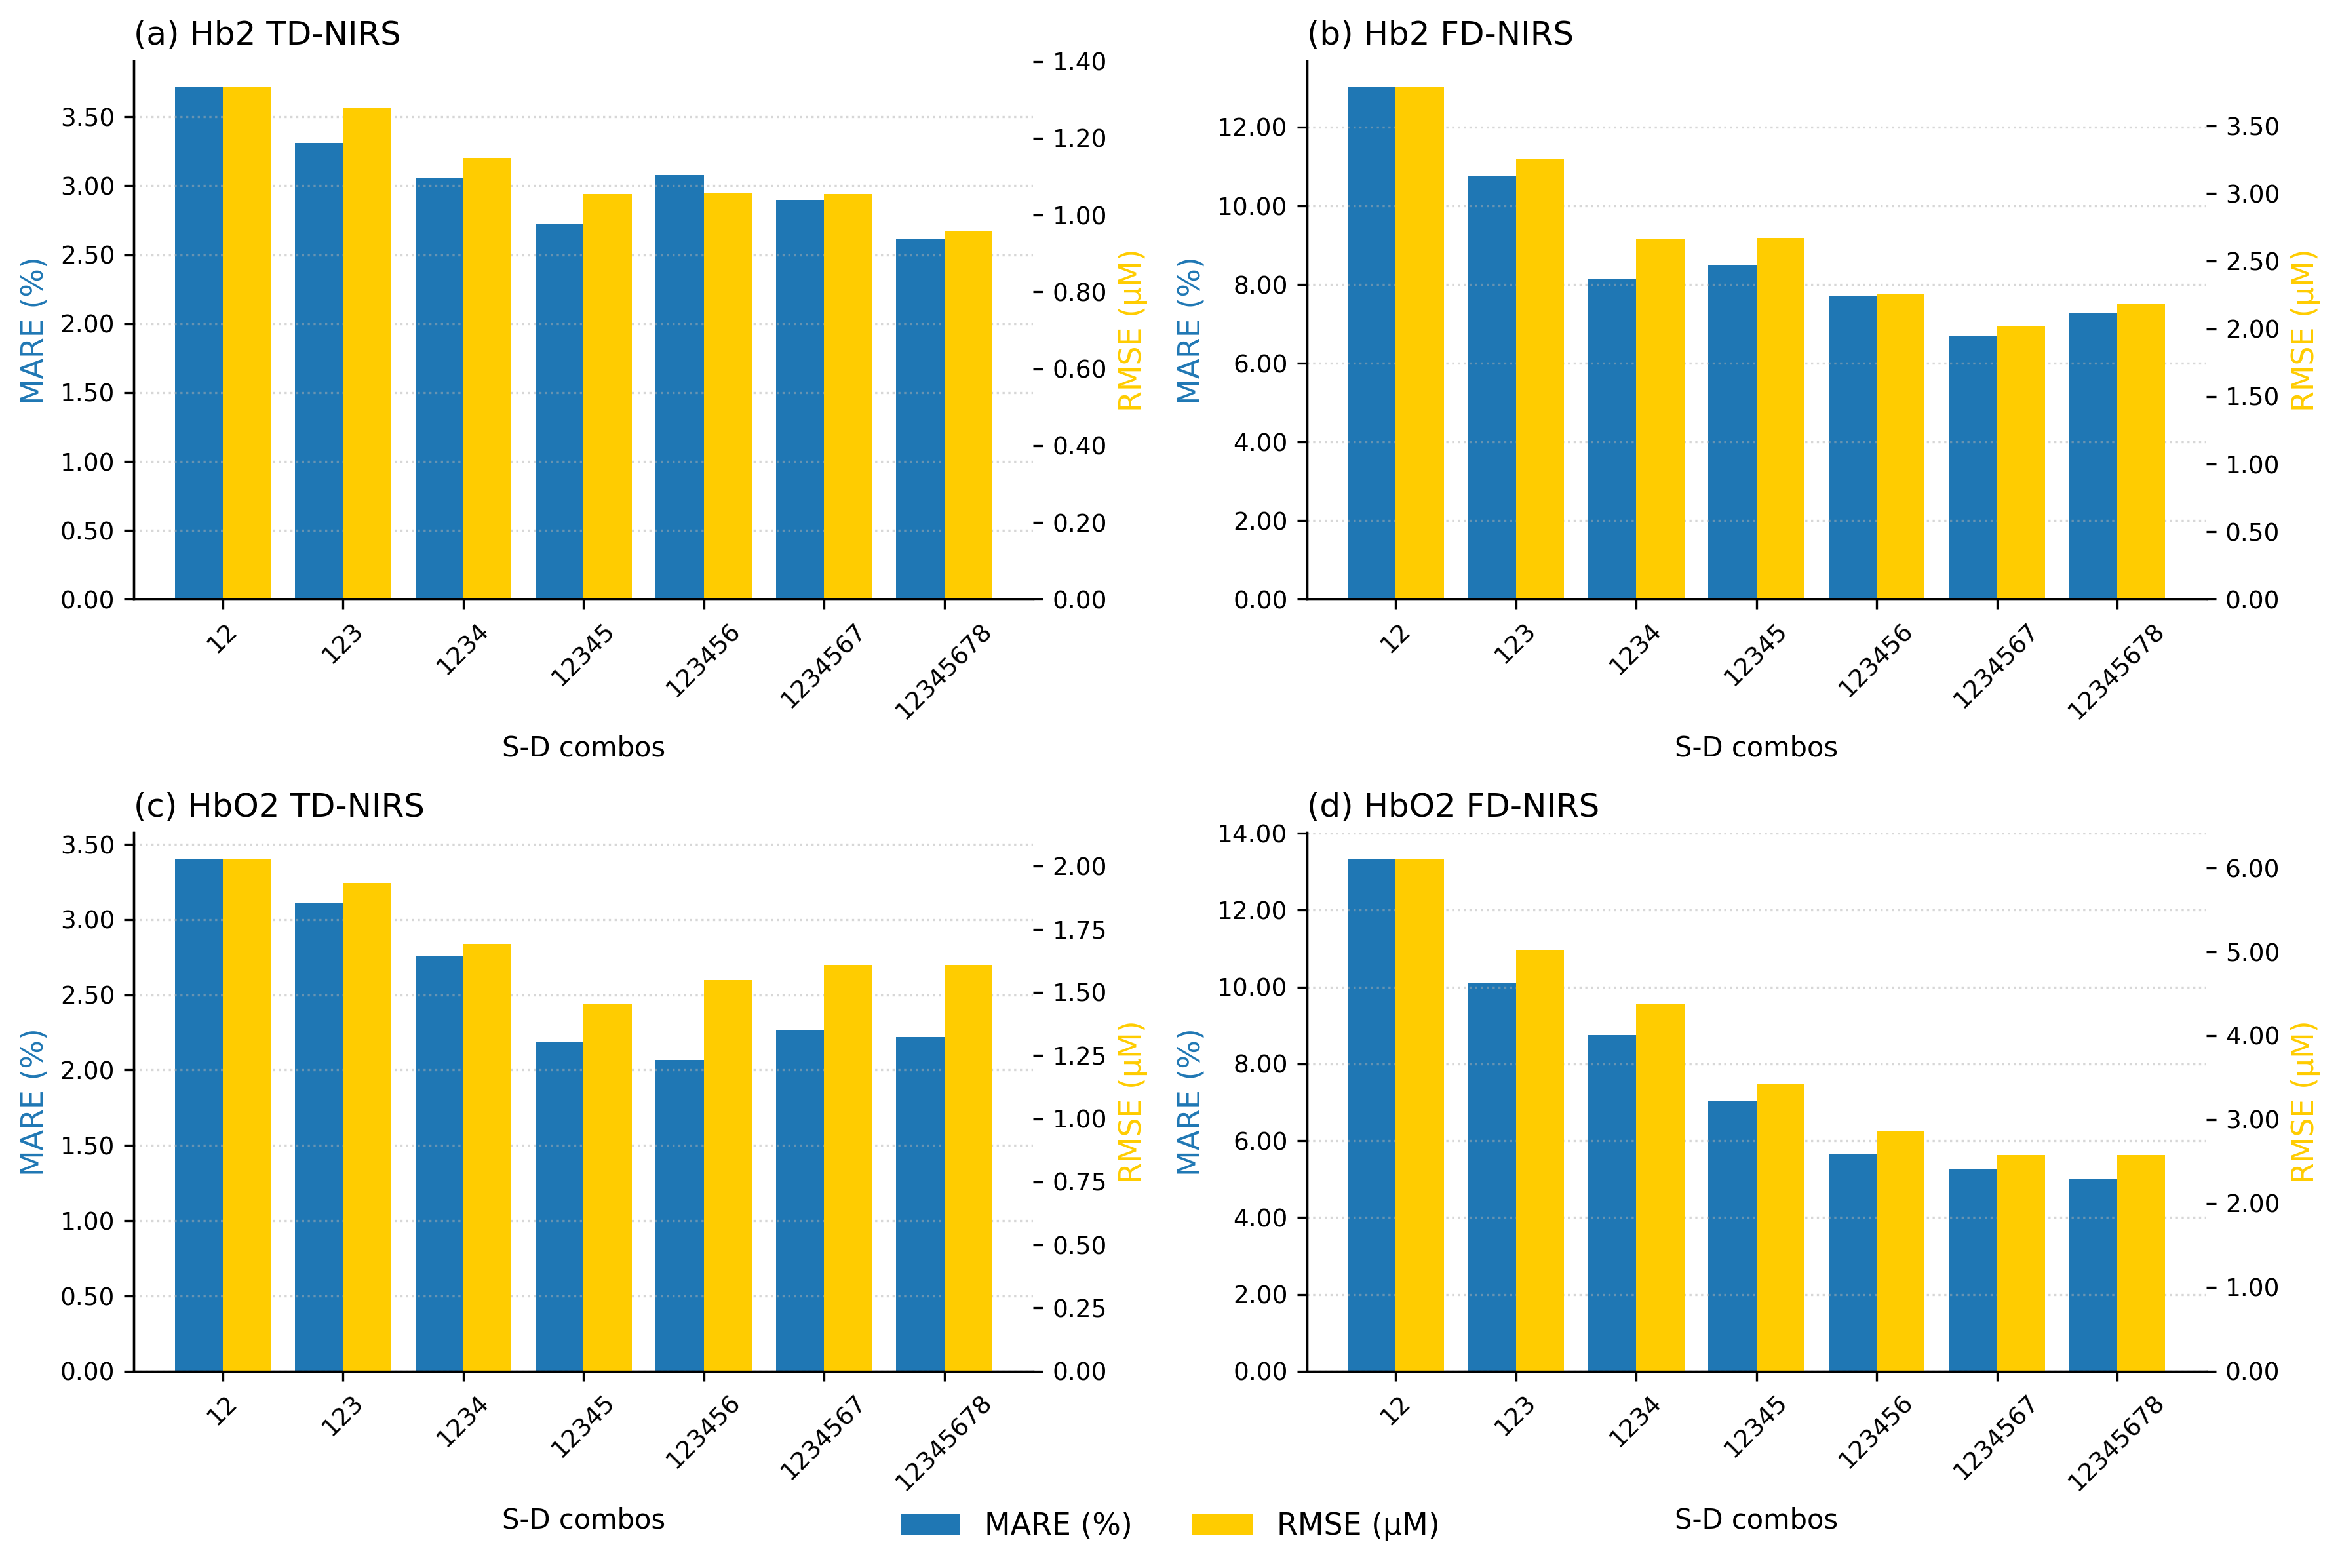

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

BLUE   = "#1f77b4"
YELLOW = "#ffcc00"

def _sorted_keys(d):
    return sorted(d.keys(), key=lambda k: (len(str(k)), k))

def _extract_series(block):
    """block = { key: {'MARE(%)': ..., 'RMSE': ...}, ... }"""
    if not block:
        return [], np.array([]), np.array([])
    keys = _sorted_keys(block)
    mare = np.array([block[k]['MARE(%)'] for k in keys])
    rmse = np.array([block[k]['RMSE']    for k in keys])
    return keys, mare, rmse

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

BLUE   = "#1f77b4"
YELLOW = "#ffcc00"

def _sorted_keys(d):
    return sorted(d.keys(), key=lambda k: (len(str(k)), k))

def _extract_series(block):
    if not block:
        return [], np.array([]), np.array([])
    keys = _sorted_keys(block)
    mare = np.array([block[k]['MARE(%)'] for k in keys])
    rmse = np.array([block[k]['RMSE']    for k in keys])
    return keys, mare, rmse

def plot_fd_td_bar_2x2(fd_metrics, td_metrics):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300)
    plt.subplots_adjust(bottom=0.18)

    panels = [
        (0, 0, 'HHB2', 'TD', '(a) Hb2 TD‑NIRS'),
        (0, 1, 'HHB2', 'FD', '(b) Hb2 FD‑NIRS'),
        (1, 0, 'HBO2', 'TD', '(c) HbO2 TD‑NIRS'),
        (1, 1, 'HBO2', 'FD', '(d) HbO2 FD‑NIRS'),
    ]

    legend_handles = None

    for (r, c, chrom, domain, title) in panels:
        ax  = axes[r, c]
        ax2 = ax.twinx()

        block = (fd_metrics if domain == 'FD' else td_metrics).get(chrom, {})
        keys, mare, rmse = _extract_series(block)
        if len(keys) == 0:
            ax.set_visible(False)
            ax2.set_visible(False)
            continue

        x = np.arange(len(keys))
        width = 0.4

        b1 = ax.bar(x - width/2, mare, width, color=BLUE,   label='MARE (%)')
        b2 = ax2.bar(x + width/2, rmse, width, color=YELLOW, label=r'RMSE (µM)')

        if legend_handles is None:
            legend_handles = (b1, b2)

        ax.set_title(title, loc='left', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels([str(k) for k in keys], rotation=45, fontsize=9)

        ax.set_xlabel('S‑D combos', fontsize=10)
        ax.set_ylabel('MARE (%)', color=BLUE, fontsize=11)
        ax2.set_ylabel(r'RMSE (µM)', color=YELLOW, fontsize=11)

        # --- force 2 decimal places & non‑negative limits ------------------ #
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))    # <<<
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))   # <<<
        ax.set_ylim(bottom=0)                                       # <<<
        ax2.set_ylim(bottom=0)                                      # <<<
        # ------------------------------------------------------------------- #

        for a in (ax, ax2):
            a.spines['top'].set_visible(False)
            a.spines['right'].set_visible(False)
            a.tick_params(axis='y', labelsize=9)
        ax.grid(axis='y', linestyle=':', alpha=0.5)

    if legend_handles is not None:
        labels = [h.get_label() for h in legend_handles]
        fig.legend(legend_handles, labels, loc='lower center', ncol=2,
                   frameon=False, fontsize=11)

    plt.tight_layout()
    plt.show()


plot_fd_td_bar_2x2(fd_metrics, td_metrics)

### 2 SD

In [5]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from typing import Dict, Tuple

def compute_fd_td_metrics(folder_path: str) -> Tuple[Dict[str, dict], Dict[str, dict]]:
    """
    Reads all CSVs named:
        distance_<key>_{hhb2|hbo2}_{FD|TD}.csv
    computes MARE(%) and RMSE for each, and returns two nested dicts:

      fd_metrics = {
        'HHB2': { key: {'MARE(%)': ..., 'RMSE': ...}, ... },
        'HBO2': { key: {'MARE(%)': ..., 'RMSE': ...}, ... },
      }

      td_metrics = {
        'HHB2': { ... },
        'HBO2': { ... },
      }
    """
    fd_metrics = {'HHB2': {}, 'HBO2': {}}
    td_metrics = {'HHB2': {}, 'HBO2': {}}

    pattern = re.compile(r'distance_(\d+)_(hhb2|hbo2)_(FD|TD)\.csv', re.IGNORECASE)

    for fname in os.listdir(folder_path):
        m = pattern.match(fname)
        if not m:
            continue

        key    = int(m.group(1))          # e.g. 12, 13, ...
        chrom  = m.group(2).upper()       # HHB2 or HBO2
        domain = m.group(3).upper()       # FD or TD
        path   = os.path.join(folder_path, fname)

        df     = pd.read_csv(path)
        y_pred = df['y_pred'].to_numpy()
        y_true = df['y_test'].to_numpy()

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mare = np.mean(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-12)) * 100

        entry = {'MARE(%)': mare, 'RMSE': rmse}
        if domain == 'FD':
            fd_metrics[chrom][key] = entry
        else:
            td_metrics[chrom][key] = entry

    # sort keys
    for chrom in fd_metrics:
        fd_metrics[chrom] = dict(sorted(fd_metrics[chrom].items()))
    for chrom in td_metrics:
        td_metrics[chrom] = dict(sorted(td_metrics[chrom].items()))

    return fd_metrics, td_metrics

def print_all_metrics(fd_metrics, td_metrics):
    for domain, metrics in (('FD', fd_metrics), ('TD', td_metrics)):
        print(f"\n{domain} metrics")
        for chrom in ('HHB2', 'HBO2'):
            entries = metrics.get(chrom, {})
            if not entries:
                print(f"  {chrom}: (none)")
                continue
            print(f"  {chrom}:")
            for key, vals in entries.items():
                print(f"    {key} → MARE={vals['MARE(%)']:.4f}%, RMSE={vals['RMSE']:.4f}")
def print_sorted_by_rmse(fd_metrics, td_metrics, top_k=None):
    blocks = [
        ("FD",  "HHB2", fd_metrics.get("HHB2", {})),
        ("FD",  "HBO2", fd_metrics.get("HBO2", {})),
        ("TD",  "HHB2", td_metrics.get("HHB2", {})),
        ("TD",  "HBO2", td_metrics.get("HBO2", {})),
    ]

    for domain, chrom, data in blocks:
        if not data:
            print(f"\n{domain} – {chrom}: (none)")
            continue

        sorted_items = sorted(data.items(), key=lambda kv: kv[1]['RMSE'])
        if top_k is not None:
            sorted_items = sorted_items[:top_k]

        print(f"\n{domain} – {chrom} (sorted by RMSE ↑):")
        for key, vals in sorted_items:
            print(f"  {key} → RMSE={vals['RMSE']:.6f}, MARE={vals['MARE(%)']:.4f}%")


In [6]:
folder = '/content/drive/MyDrive/MCX_data/distance_2/'
fd_metrics, td_metrics = compute_fd_td_metrics(folder)
print_all_metrics(fd_metrics, td_metrics)


FD metrics
  HHB2:
    12 → MARE=13.0267%, RMSE=3.7912
    13 → MARE=12.2277%, RMSE=3.5494
    14 → MARE=10.7747%, RMSE=3.1504
    15 → MARE=9.4497%, RMSE=2.8913
    16 → MARE=9.9232%, RMSE=3.0093
    17 → MARE=9.3901%, RMSE=2.9045
    18 → MARE=10.8315%, RMSE=3.1422
    23 → MARE=12.3737%, RMSE=3.6514
    24 → MARE=11.2705%, RMSE=3.3718
    25 → MARE=10.6189%, RMSE=3.2591
    26 → MARE=9.7756%, RMSE=2.9974
    27 → MARE=10.0458%, RMSE=3.0616
    28 → MARE=9.5337%, RMSE=2.8688
    34 → MARE=12.3104%, RMSE=3.6919
    35 → MARE=10.5717%, RMSE=3.1838
    36 → MARE=9.6956%, RMSE=2.8713
    37 → MARE=10.1022%, RMSE=3.0467
    38 → MARE=10.0332%, RMSE=3.0928
    45 → MARE=11.9144%, RMSE=3.5360
    46 → MARE=10.3998%, RMSE=3.1209
    47 → MARE=10.3214%, RMSE=3.0983
    48 → MARE=11.0153%, RMSE=3.1956
    56 → MARE=12.9723%, RMSE=3.7493
    57 → MARE=12.0325%, RMSE=3.4915
    58 → MARE=11.0242%, RMSE=3.3329
    67 → MARE=13.3619%, RMSE=3.9109
    68 → MARE=11.9690%, RMSE=3.5314
    78 → MARE=

In [7]:
print_sorted_by_rmse(fd_metrics, td_metrics)


FD – HHB2 (sorted by RMSE ↑):
  28 → RMSE=2.868777, MARE=9.5337%
  36 → RMSE=2.871324, MARE=9.6956%
  15 → RMSE=2.891299, MARE=9.4497%
  17 → RMSE=2.904509, MARE=9.3901%
  26 → RMSE=2.997409, MARE=9.7756%
  16 → RMSE=3.009299, MARE=9.9232%
  37 → RMSE=3.046743, MARE=10.1022%
  27 → RMSE=3.061590, MARE=10.0458%
  38 → RMSE=3.092784, MARE=10.0332%
  47 → RMSE=3.098330, MARE=10.3214%
  46 → RMSE=3.120935, MARE=10.3998%
  18 → RMSE=3.142169, MARE=10.8315%
  14 → RMSE=3.150393, MARE=10.7747%
  35 → RMSE=3.183787, MARE=10.5717%
  48 → RMSE=3.195599, MARE=11.0153%
  25 → RMSE=3.259144, MARE=10.6189%
  58 → RMSE=3.332865, MARE=11.0242%
  24 → RMSE=3.371837, MARE=11.2705%
  57 → RMSE=3.491523, MARE=12.0325%
  68 → RMSE=3.531359, MARE=11.9690%
  45 → RMSE=3.535976, MARE=11.9144%
  13 → RMSE=3.549381, MARE=12.2277%
  23 → RMSE=3.651444, MARE=12.3737%
  34 → RMSE=3.691858, MARE=12.3104%
  56 → RMSE=3.749261, MARE=12.9723%
  12 → RMSE=3.791165, MARE=13.0267%
  78 → RMSE=3.825554, MARE=12.7997%
  6

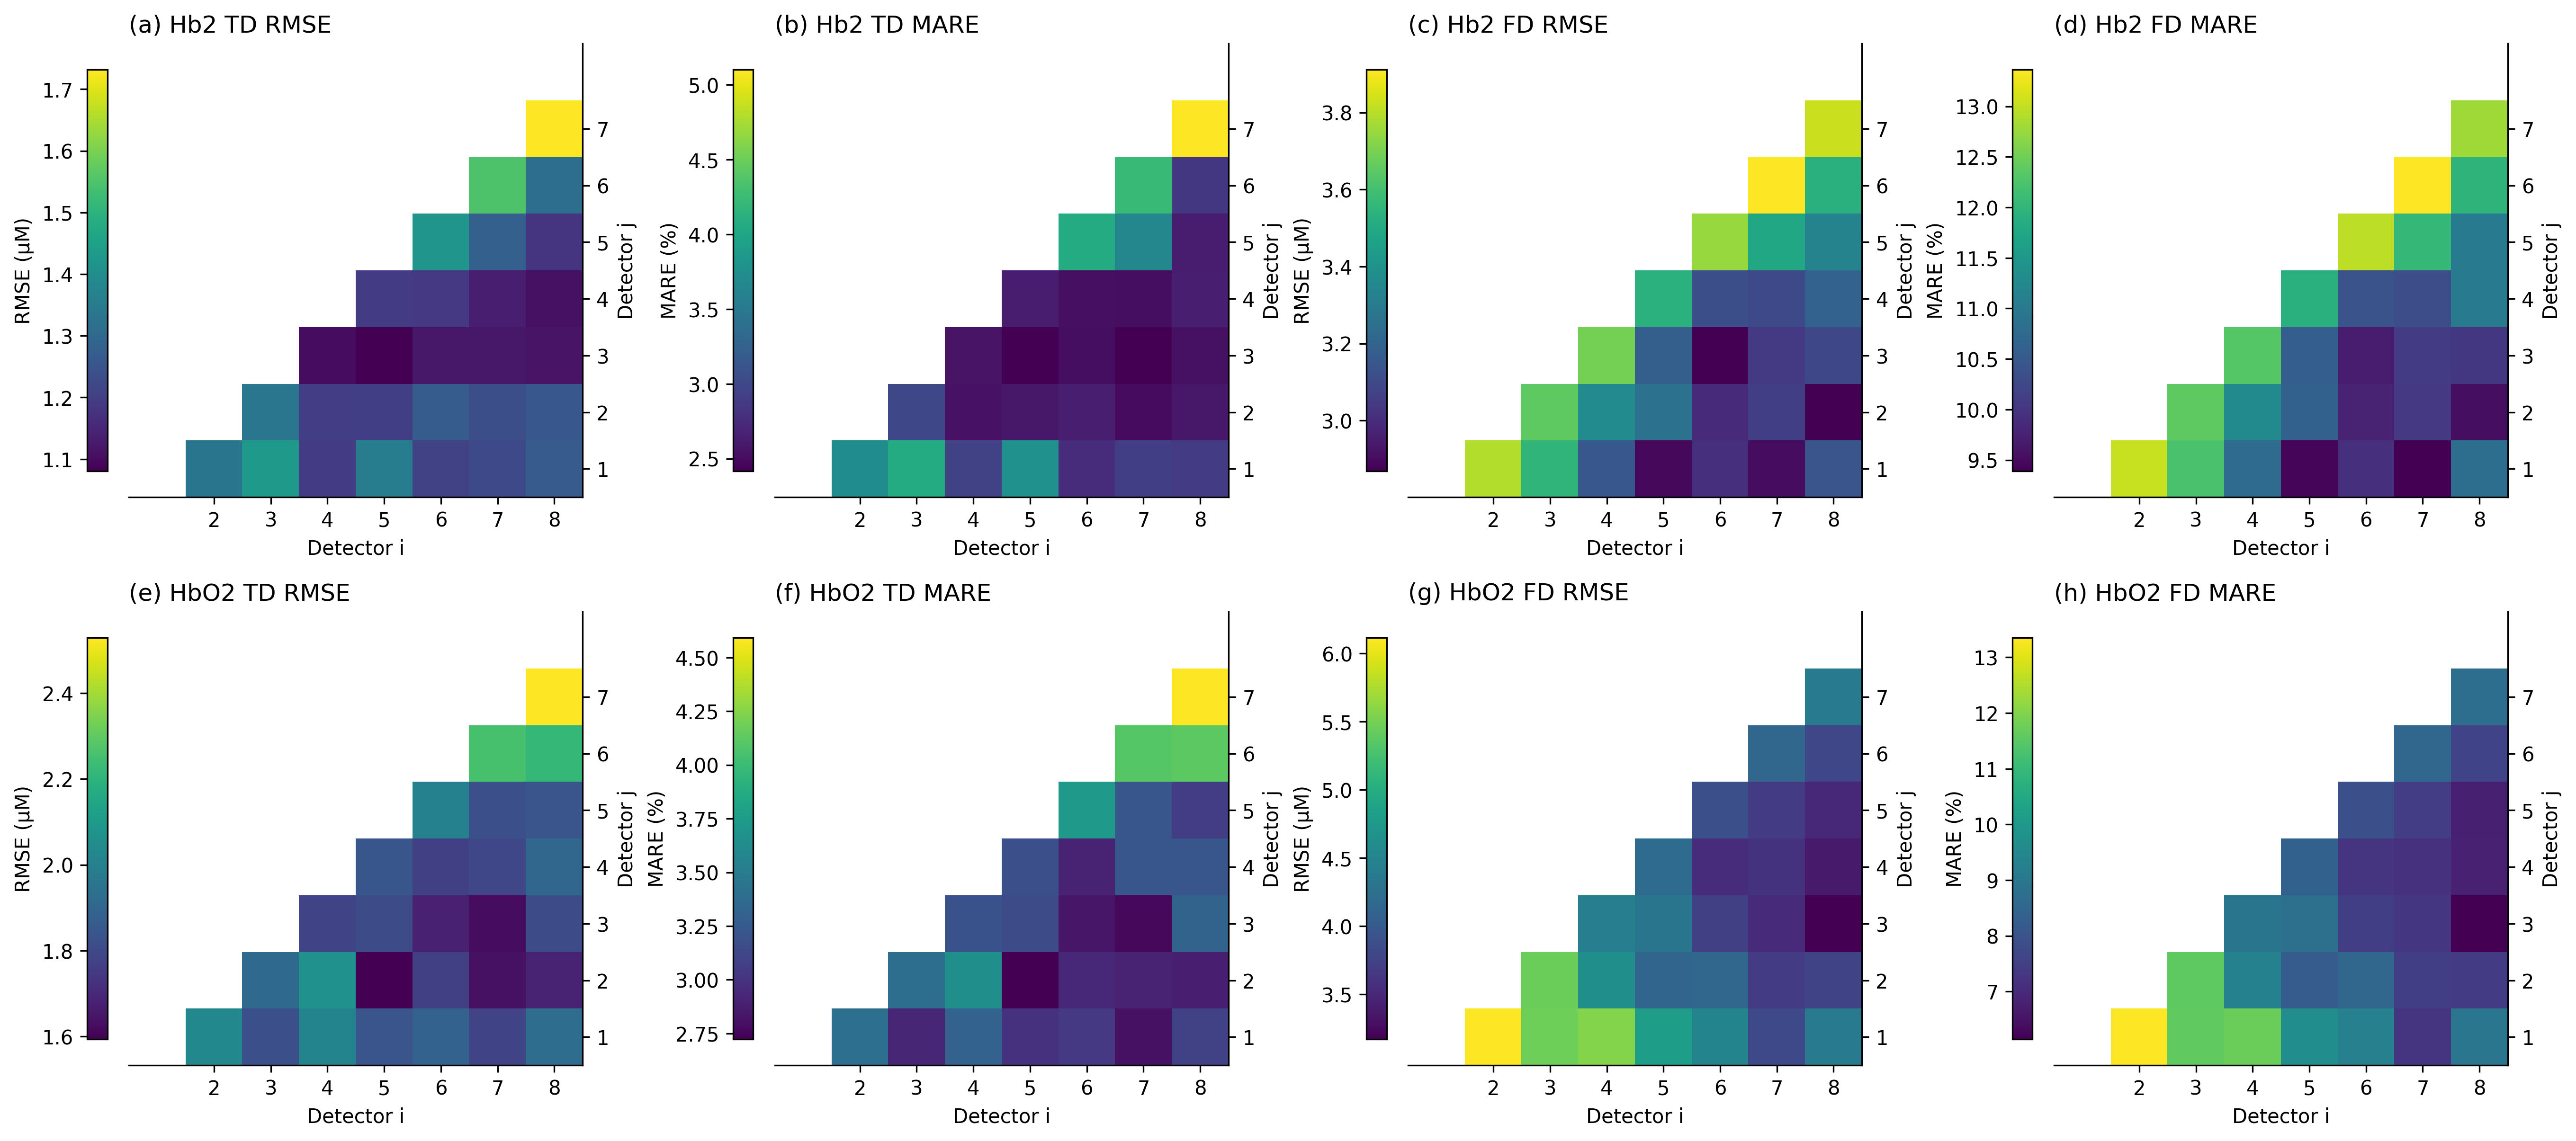

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_heatmaps_custom(fd_metrics: dict, td_metrics: dict):
    """
    2 × 4 panel heatmaps:

        Cols:  TD‑RMSE | TD‑MARE | FD‑RMSE | FD‑MARE
        Row1:  Hb2  (HHB2)
        Row2:  HbO2 (HBO2)
    """
    n = 8  # detectors

    # NEW column order: TD first, FD second
    col_specs = [
        ('TD', 'RMSE',    'RMSE (μM)',  'TD RMSE'),
        ('TD', 'MARE(%)', 'MARE (%)',   'TD MARE'),
        ('FD', 'RMSE',    'RMSE (μM)',  'FD RMSE'),
        ('FD', 'MARE(%)', 'MARE (%)',   'FD MARE'),
    ]

    row_specs = [
        ('HHB2', 'Hb2'),
        ('HBO2', 'HbO2'),
    ]

    domain_dict = {'FD': fd_metrics, 'TD': td_metrics}

    fig, axes = plt.subplots(2, 4, figsize=(18, 8), dpi=300, constrained_layout=True)

    cmap = mpl.colormaps['viridis'].copy()
    cmap.set_bad(color='white')

    for r, (chrom, chrom_label) in enumerate(row_specs):
        for c, (dom, met_key, met_label, col_title) in enumerate(col_specs):
            ax = axes[r, c]
            dom_dict = domain_dict[dom].get(chrom, {})

            # ── build 8×8 matrix Z ─────────────────────────────────────────
            Z = np.full((n, n), np.nan)
            for key, vals in dom_dict.items():
                s = str(key)
                if len(s) == 2 and s.isdigit():
                    i, j = int(s[0]) - 1, int(s[1]) - 1
                    if 0 <= i < n and 0 <= j < n:
                        Z[i, j] = Z[j, i] = vals[met_key]

            # keep lower‑right triangle (j ≥ i)
            Z = np.where(np.tril(np.ones_like(Z), k=-1), np.nan, Z)

            im = ax.imshow(np.ma.masked_invalid(Z), origin='lower',
                           extent=(0, n, 0, n), aspect='equal', cmap=cmap)

            # centered ticks
            centres = np.arange(0.5, n, 1)
            labels  = np.arange(1,   n + 1)
            ax.set_xticks(centres[labels != 1], labels[labels != 1])
            ax.set_yticks(centres[labels != n], labels[labels != n])

            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)

            fig.colorbar(im, ax=ax, orientation='vertical',
                         shrink=0.8, pad=0.04, label=met_label, location='left')

            ax.set_xlabel('Detector i')
            ax.set_ylabel('Detector j')
            letter = chr(ord('a') + r * 4 + c)
            ax.set_title(f'({letter}) {chrom_label} {col_title}', loc='left')

    plt.show()


plot_heatmaps_custom(fd_metrics, td_metrics)